<h1>Regularization</h1>
<ul>
    <li>Regularization</li>
    <li>Dropout</li>

<h2>Import Dependencies</h2>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec, compute_cost, predict, forward_propagation, backward_propagation, update_parameters

<h2>Loading Dataset</h2>

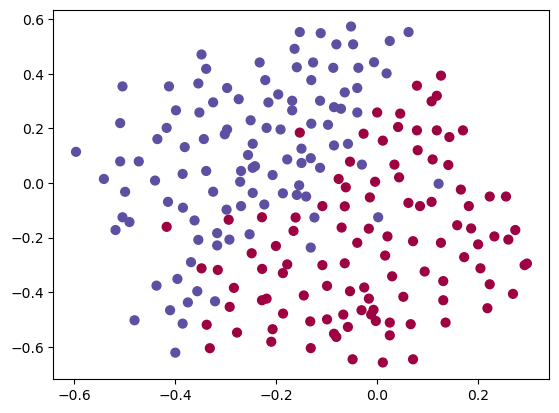

In [4]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

<h2>Non-Regularized Model</h2>

In [5]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    '''
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Args:
    X -- input data, of shape 
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    '''
    
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims = [X.shape[0], 20, 3, 1]
    
    parameters = initialize_parameters(layers_dims)
    
    for i in range(num_iterations):
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
    
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
        
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
         
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.16329987525724213
Cost after iteration 20000: 0.1385164242325169


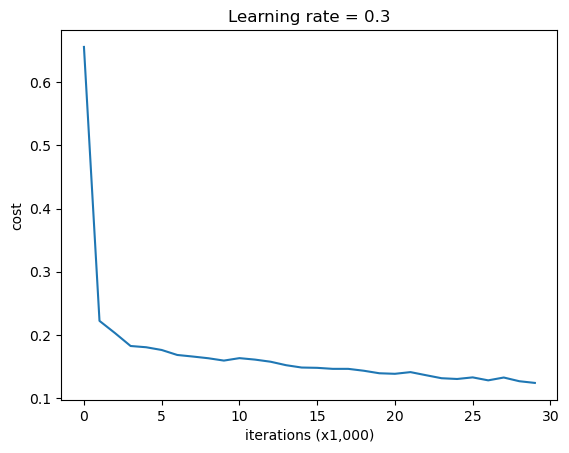

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


In [6]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

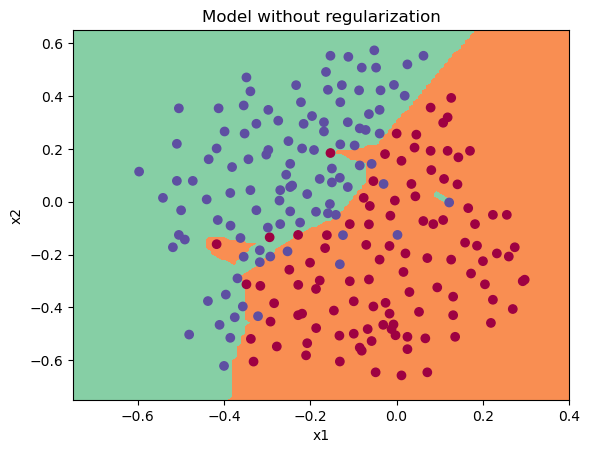

In [7]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

<h2>L2 Regularization</h2>

<h3>Compute cost with regularization</h3>

In [8]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    '''
    compute cost with regularization term
    
    Args:
    A3 -- the forward pass output
    Y -- the corresponding labels
    parameters -- weights and bias
    lambd -- regularization term
    
    Returns:
    cost -- network cost
    '''
    
    m = Y.shape[1]
    cost_forward = -(1/m) * np.sum(Y * np.log(A3) + (1-Y) * np.log(1-A3)) 
    cost_regularization = 0
    for i in range(1, len(parameters) // 2):
        cost_i = np.sum(np.square(parameters['W' + str(i)]))
        cost_regularization += cost_i
    cost = cost_forward + (1/m) * (lambd/2) * cost_regularization
    return cost

In [9]:
np.random.seed(1)
Y_test = np.array([[1, 1, 0, 1, 0]])
W1 = np.random.randn(2, 3)
b1 = np.random.randn(2, 1)
W2 = np.random.randn(3, 2)
b2 = np.random.randn(3, 1)
W3 = np.random.randn(1, 3)
b3 = np.random.randn(1, 1)
parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
a3 = np.array([[ 0.40682402,  0.01629284,  0.16722898,  0.10118111,  0.40682402]])

In [10]:
cost = compute_cost_with_regularization(a3, Y_test, parameters, lambd=0.1)
print("cost = " + str(cost))

cost = 1.775365035402418


<h3>Backward propagation with regularization</h3>

In [11]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    '''
    Add regularization gradient to weights
    
    Args:
    X -- training set
    Y -- training label
    cache -- intermediate variables for backward propagation
    lambd -- regularization term
    
    Returns:
    grads -- gradients contain regularization 
    '''
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = (1/m) * np.dot(dZ3, A2.T) + (lambd/m) * W3
    db3 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)

    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = (1/m) * np.dot(dZ2, A1.T) + (lambd/m) * W2
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = (1/m) * np.dot(dZ1, X.T) + (lambd/m) * W1
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {
        'dA1': dA1, 'dW1': dW1, 'db1': db1, 'dZ1': dZ1,
        'dA2': dA2, 'dW2': dW2, 'db2': db2, 'dZ2': dZ2,
                    'dW3': dW3, 'db3': db3, 'dZ3': dZ3,
    }
    
    return grads

In [12]:
np.random.seed(1)
X_test = np.random.randn(3, 5)
Y_test = np.array([[1, 1, 0, 1, 0]])
cache = (np.array([[-1.52855314,  3.32524635,  2.13994541,  2.60700654, -0.75942115],
     [-1.98043538,  4.1600994 ,  0.79051021,  1.46493512, -0.45506242]]),
np.array([[ 0.        ,  3.32524635,  2.13994541,  2.60700654,  0.        ],
     [ 0.        ,  4.1600994 ,  0.79051021,  1.46493512,  0.        ]]),
np.array([[-1.09989127, -0.17242821, -0.87785842],
     [ 0.04221375,  0.58281521, -1.10061918]]),
np.array([[ 1.14472371],
     [ 0.90159072]]),
np.array([[ 0.53035547,  5.94892323,  2.31780174,  3.16005701,  0.53035547],
     [-0.69166075, -3.47645987, -2.25194702, -2.65416996, -0.69166075],
     [-0.39675353, -4.62285846, -2.61101729, -3.22874921, -0.39675353]]),
np.array([[ 0.53035547,  5.94892323,  2.31780174,  3.16005701,  0.53035547],
     [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
     [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]),
np.array([[ 0.50249434,  0.90085595],
     [-0.68372786, -0.12289023],
     [-0.93576943, -0.26788808]]),
np.array([[ 0.53035547],
     [-0.69166075],
     [-0.39675353]]),
np.array([[-0.3771104 , -4.10060224, -1.60539468, -2.18416951, -0.3771104 ]]),
np.array([[ 0.40682402,  0.01629284,  0.16722898,  0.10118111,  0.40682402]]),
np.array([[-0.6871727 , -0.84520564, -0.67124613]]),
np.array([[-0.0126646]]))

In [13]:
grads = backward_propagation_with_regularization(X_test, Y_test, cache, lambd = 0.7)
print ("dW1 = \n"+ str(grads["dW1"]))
print ("dW2 = \n"+ str(grads["dW2"]))
print ("dW3 = \n"+ str(grads["dW3"]))

dW1 = 
[[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = 
[[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = 
[[-1.77691347 -0.11832879 -0.09397446]]


Cost after iteration 0: 0.6960971224473486
Cost after iteration 10000: 0.254143524150005
Cost after iteration 20000: 0.25258372089544073


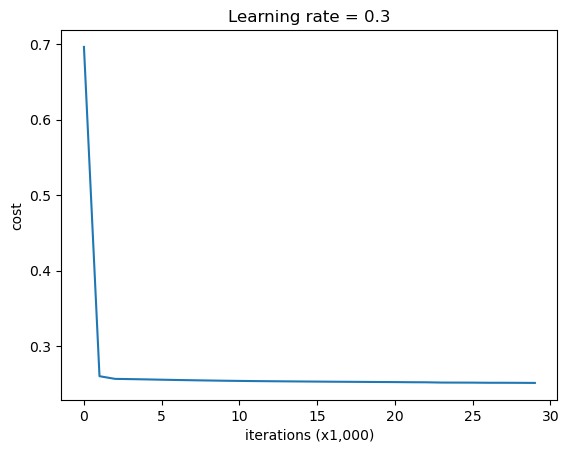

On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


In [14]:
# training with regularization

parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

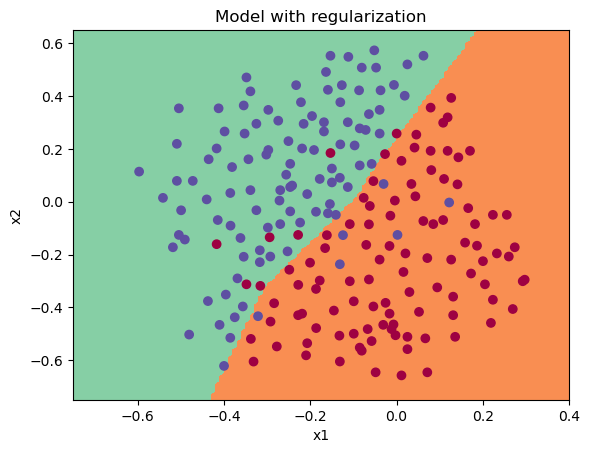

In [15]:
plt.title("Model with regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

<h2>Dropout</h2>

<h3>Forward propagation with dropout</h3>

In [78]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    '''
    forward propagation with dropout 
    
    Args:
    X -- training set
    parameters -- weights and bias
    keep_prob -- probability of keep neurons "alive"
    
    Returns:
    A3 -- forward output
    cache -- for backward propagation 
    '''
    np.random.seed(1)
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    D1 = np.random.rand(A1.shape[0], A1.shape[1])
    D1 = (D1 < keep_prob).astype(int)
    A1 = A1 * D1    
    A1 = A1 / keep_prob
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)    
    D2 = np.random.rand(A2.shape[0], A2.shape[1])
    D2 = (D2 < keep_prob).astype(int)    
    A2 = A2 * D2
    A2 = A2 / keep_prob
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)

    return A3, cache 

In [79]:
np.random.seed(1)
X_test = np.random.randn(3, 5)
W1 = np.random.randn(2, 3)
b1 = np.random.randn(2, 1)
W2 = np.random.randn(3, 2)
b2 = np.random.randn(3, 1)
W3 = np.random.randn(1, 3)
b3 = np.random.randn(1, 1)
parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}

A3, cache = forward_propagation_with_dropout(X_test, parameters, keep_prob = 0.5)
print ("A3 = " + str(A3))

A3 = [[0.32266394 0.49683389 0.00348883 0.49683389 0.32266394]]


<h3>Backward propagation with dropout</h3>

In [80]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    '''
    backward propagation with dropout
    
    Args:
    X -- training data
    Y -- training label
    cache -- intermediate variables for backprop 
    keep_prob -- probability to keep neurons alive
    
    Returns:
    grads -- gradients
    '''
    
    grads = {}
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = (1/m) * np.dot(dZ3, A2.T)
    db3 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dA2 = dA2 * D2
    dA2 = dA2 / keep_prob
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = dA1 * D1
    dA1 = dA1 / keep_prob
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {
        'dZ3': dZ3, 'dW3': dW3, 'db3': db3, 
        'dA2': dA2, 'dZ2': dZ2, 'dW2': dW2, 'db2': db2,
        'dA1': dA1, 'dZ1': dZ1, 'dW1': dW1, 'db1': db1
    }
    
    return grads

In [81]:
np.random.seed(1)
X_test = np.random.randn(3, 5)
Y_test = np.array([[1, 1, 0, 1, 0]])
cache = (np.array([[-1.52855314,  3.32524635,  2.13994541,  2.60700654, -0.75942115],
   [-1.98043538,  4.1600994 ,  0.79051021,  1.46493512, -0.45506242]]), np.array([[ True, False,  True,  True,  True],
   [ True,  True,  True,  True, False]], dtype=bool), np.array([[ 0.        ,  0.        ,  4.27989081,  5.21401307,  0.        ],
   [ 0.        ,  8.32019881,  1.58102041,  2.92987024,  0.        ]]), np.array([[-1.09989127, -0.17242821, -0.87785842],
   [ 0.04221375,  0.58281521, -1.10061918]]), np.array([[ 1.14472371],
   [ 0.90159072]]), np.array([[ 0.53035547,  8.02565606,  4.10524802,  5.78975856,  0.53035547],
   [-0.69166075, -1.71413186, -3.81223329, -4.61667916, -0.69166075],
   [-0.39675353, -2.62563561, -4.82528105, -6.0607449 , -0.39675353]]), np.array([[ True, False,  True, False,  True],
   [False,  True, False,  True,  True],
   [False, False,  True, False, False]], dtype=bool), np.array([[ 1.06071093,  0.        ,  8.21049603,  0.        ,  1.06071093],
   [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
   [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]), np.array([[ 0.50249434,  0.90085595],
   [-0.68372786, -0.12289023],
   [-0.93576943, -0.26788808]]), np.array([[ 0.53035547],
   [-0.69166075],
   [-0.39675353]]), np.array([[-0.7415562 , -0.0126646 , -5.65469333, -0.0126646 , -0.7415562 ]]), np.array([[ 0.32266394,  0.49683389,  0.00348883,  0.49683389,  0.32266394]]), np.array([[-0.6871727 , -0.84520564, -0.67124613]]), np.array([[-0.0126646]]))

In [82]:
gradients = backward_propagation_with_dropout(X_test, Y_test, cache, keep_prob = 0.8)

print ("dA1 = \n" + str(gradients["dA1"]))
print ("dA2 = \n" + str(gradients["dA2"]))

dA1 = 
[[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = 
[[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


Cost after iteration 0: 0.6543912405149825
Cost after iteration 10000: 0.061016986574905605
Cost after iteration 20000: 0.060582435798513114


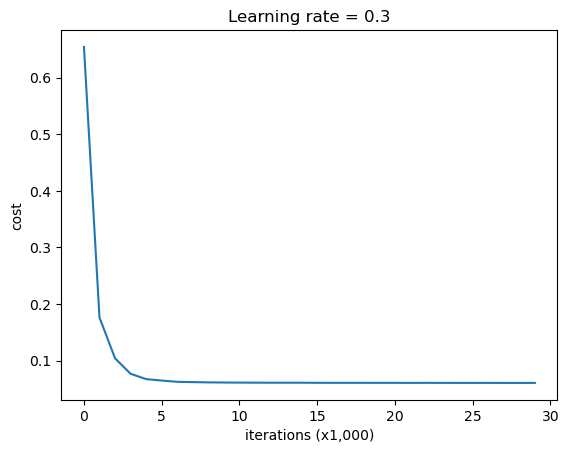

On the train set:
Accuracy: 0.9289099526066351
On the test set:
Accuracy: 0.95


In [83]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

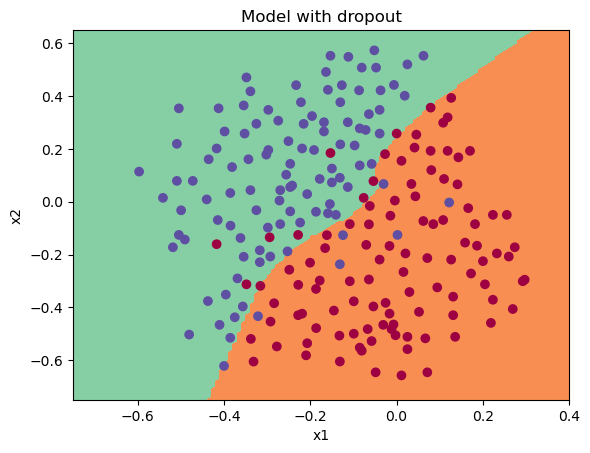

In [84]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)